In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from scipy.stats import entropy
from sklearn.cluster import AgglomerativeClustering

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [2]:
# calculate entropy
def calentropy(feature, bins = 20):
    c = np.histogram(np.array(df_copy[feature]), bins = 20)[0]
    n_c = c/c.sum()
    return entropy(n_c, base = 2)

In [3]:
# data preprocess for ANN
def ANN_setup(X, y, tsize=0.3, random_state=None):
    train_value, test_value, train_label, test_label = train_test_split(X, y, test_size=tsize, stratify=y, 
                                                                        random_state=random_state)
    
    # scale and shift attributes to [0, 1]
    minAttr = train_value.min(axis=0)
    maxAttr = train_value.max(axis=0)
    rangeAttr = maxAttr - minAttr
    
    train_value -= minAttr
    train_value = (train_value/rangeAttr)
    
    test_value -= minAttr
    test_value = (test_value/rangeAttr)
    
    # return arrays for training and testing
    return train_value, test_value, train_label, test_label, maxAttr, minAttr

# exclude samples to balance class weights
def exl_sample(X, y, n, lab):
    lst = []; c = 0
    for s in range(len(y)):
        if y[s, lab]:
            lst.append(s)
            if len(lst) == n:
                break
    return np.delete(X, lst, axis=0), np.delete(np.array(y), lst, axis=0)

In [4]:
# predefined colors in figures
colors = ['#539fac', '#c84947','#f5b23e']
kcolor = ['#fcba03', '#2e74c2', '#79b178', '#ca5d53', '#7d6285', '#a8a497']

### Import data

In [5]:
# load data
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
ctc = CellTypesCache(manifest_file = 'cell_types/manifest.json')

In [6]:
# download electrophysiology features of all cells
ephys_features = ctc.get_ephys_features()
ef_df = pd.DataFrame(ephys_features)
# download basic cell information from human neurons
cells = ctc.get_cells(species = [CellTypesApi.HUMAN])
cell_df = pd.DataFrame(cells)

cell_df = cell_df[['id','dendrite_type', 'structure_area_abbrev']].rename(columns={'id': 'specimen_id'})
all_df = pd.merge(left = cell_df.set_index('specimen_id'), right = ef_df, 
                  how = 'inner', left_on = 'specimen_id', right_on = 'specimen_id')

In [7]:
# exclude integer and binary features
all_df = all_df.drop(columns = ['id', 'thumbnail_sweep_id', 'rheobase_sweep_id', 'rheobase_sweep_number', 
                                'has_burst', 'has_delay', 'has_pause'])
# exclude features where over 30% of values are missing
all_df = all_df.drop(columns= ['slow_trough_t_long_square', 'slow_trough_t_ramp', 'slow_trough_t_short_square', 
                               'slow_trough_v_long_square', 'slow_trough_v_ramp', 'slow_trough_v_short_square'])
# exclude mechanical features that are irrelevant to the intrinsic characteristics of the neurons
all_df = all_df.drop(columns= ['electrode_0_pa', 'seal_gohm'])

# impute missing values
all_df['avg_isi'].fillna(1000, inplace=True) # 1000ms is the maximum value
all_df['adaptation'].fillna(1, inplace=True) 

# exclude cells containing null values in the electrophysiological features
nanlst = []
for cell in range(len(all_df)):
    if True in list(all_df.loc[cell].isnull()):
        nanlst.append(cell)
all_df = all_df.drop(nanlst)

In [8]:
d_type = {}
for n in all_df['dendrite_type']:
    if n not in d_type:
        d_type[n] = 0
    d_type[n] += 1
    
print('Types of dentrites: ')
print(d_type)

Types of dentrites: 
{'spiny': 321, 'aspiny': 78, 'sparsely spiny': 13}


In [9]:
# label encoding for supervised learning
label_encoder = LabelEncoder()

d_cat = all_df['dendrite_type']
d_lab = label_encoder.fit_transform(d_cat)
all_df['dendrite_label'] = d_lab

In [10]:
# split data to values and labels
X = all_df.drop(['specimen_id', 'dendrite_type', 'structure_area_abbrev', 'dendrite_label'], axis=1).to_numpy()
y = all_df['dendrite_label'].to_numpy()

target_names=['aspiny', 'sparsely spiny', 'spiny']

### Random forest

In [11]:
f1_rf = []; acy_rf = []
conf_rf = np.zeros((3, 3))
n_s=0; n_sp=0; n_a=0

# construct random forest classifier
rf_clf = RandomForestClassifier(max_features=40, n_estimators=100)

for n in range(100):
    # split dataset to training and test
    train_value, test_value, train_label, test_label = train_test_split(X, y, test_size=0.3, stratify=y)
    # train classifier
    rf_clf.fit(train_value, train_label)
    
    # sample number of each class in testing set
    n_a += (test_label==0).sum()
    n_sp += (test_label==1).sum()
    n_s += (test_label==2).sum()

    # Make predictions
    rf_predictions = rf_clf.predict(test_value)
    
    # calculate evaluation parameters
    f1_rf.append(metrics.f1_score(test_label, rf_predictions, average='weighted'))
    acy_rf.append(metrics.accuracy_score(test_label, rf_predictions))
    conf = metrics.confusion_matrix(test_label, rf_predictions, normalize='true')
    conf_rf += conf

No handles with labels found to put in legend.
No handles with labels found to put in legend.


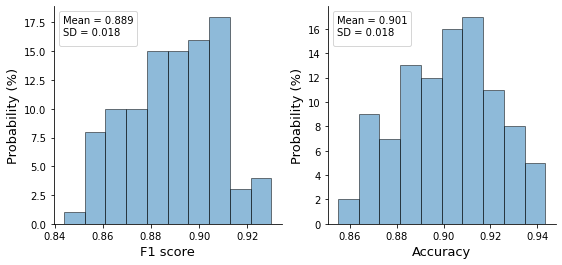

In [12]:
fig = plt.figure(figsize=(9, 4))
plt.tight_layout()

# f1 score
ax = fig.add_subplot(1, 2, 1)
plt.hist(f1_rf, bins=10, alpha=0.5, edgecolor='black', linewidth=1)
plt.xlabel('F1 score', fontsize=13)
plt.ylabel('Probability (%)', fontsize=13)
plt.legend(title = 'Mean = '+str(np.array(f1_rf).mean())[:5]+ '\nSD = '+str(np.std(np.array(f1_rf)))[:5], loc='upper left')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# accuracy
ax = fig.add_subplot(1, 2, 2)
plt.hist(acy_rf, bins=10, alpha=0.5, edgecolor='black', linewidth=1)
plt.xlabel('Accuracy', fontsize=13)
plt.ylabel('Probability (%)', fontsize=13)
plt.legend(title = 'Mean = '+str(np.array(acy_rf).mean())[:5]+ '\nSD = '+str(np.std(np.array(acy_rf)))[:5], loc='upper left')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

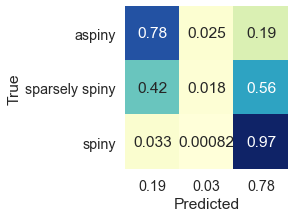

In [13]:
sns.set(rc={'figure.figsize':(3,3)})
sns.set(font_scale=1.3)
ylab = [round(n_a/(n_a+n_sp+n_s),2), round(n_sp/(n_a+n_sp+n_s),2), round(n_s/(n_a+n_sp+n_s),2)]
sns.heatmap(conf_rf/100, annot=True, xticklabels=ylab, yticklabels=target_names, cmap='YlGnBu', 
            square=True, vmax=1, vmin=0, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.yticks(rotation=0)

In [14]:
train_value, test_value, train_label, test_label = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)
rf_clf.fit(train_value, train_label)
rf_clf_predictions = rf_clf.predict_proba(test_value)

# Compute ROC curve and ROC area for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(3):
    fpr_rf[i], tpr_rf[i], _ = metrics.roc_curve(label_binarize(test_label, classes=[0, 1, 2])[:,i], 
                                                rf_clf_predictions[:,i]) # binarize labels
    roc_auc_rf[i] = metrics.auc(fpr_rf[i], tpr_rf[i])

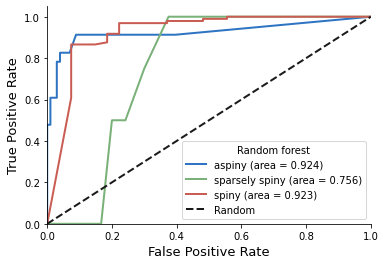

In [15]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

fig = plt.figure(figsize=(5.8, 4))
ax = fig.add_subplot(1, 1, 1)
for i, color in zip(range(3), kcolor[1:4]):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=2, label=target_names[i] + ' (area = '+str(roc_auc_rf[i])[:5]+')')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.legend(title='Random forest', loc="lower right")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

### K nearest neighbor

In [16]:
f1_knnb = []; acy_knnb = []
conf_knnb = np.zeros((3, 3))

# construct knn classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn_bag = BaggingClassifier(knn, max_samples=0.5, max_features=0.5)

for n in range(100):
    # split dataset to training and test
    train_value, test_value, train_label, test_label = train_test_split(X, y, test_size=0.3, stratify=y)
    # train classifiers
    knn_bag.fit(train_value, train_label)

    # Make predictions
    knn_bag_predictions = knn_bag.predict(test_value)
    
    # calculate evaluation parameters
    f1_knnb.append(metrics.f1_score(test_label, knn_bag_predictions, average='weighted'))
    acy_knnb.append(metrics.accuracy_score(test_label, knn_bag_predictions))
    confb = metrics.confusion_matrix(test_label, knn_bag_predictions, normalize='true')

    conf_knnb += confb

No handles with labels found to put in legend.
No handles with labels found to put in legend.


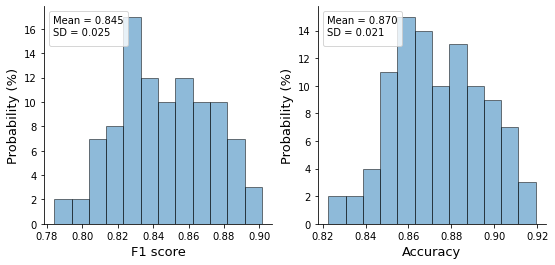

In [17]:
fig = plt.figure(figsize=(9, 4))
plt.tight_layout()

# f1 score
ax = fig.add_subplot(1, 2, 1)
plt.hist(f1_knnb, bins=12, alpha=0.5, edgecolor='black', linewidth=1)
plt.xlabel('F1 score', fontsize=13)
plt.ylabel('Probability (%)', fontsize=13)
plt.legend(title = 'Mean = '+str(np.array(f1_knnb).mean())[:5]+ '\nSD = '+str(np.std(np.array(f1_knnb)))[:5], loc='upper left')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# accuracy
ax = fig.add_subplot(1, 2, 2)
plt.hist(acy_knnb, bins=12, alpha=0.5, edgecolor='black', linewidth=1)
plt.xlabel('Accuracy', fontsize=13)
plt.ylabel('Probability (%)', fontsize=13)
plt.legend(title = 'Mean = '+str(np.array(acy_knnb).mean())[:5]+ '\nSD = '+str(np.std(np.array(acy_knnb)))[:5], loc='upper left')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

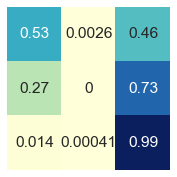

In [18]:
sns.set(rc={'figure.figsize':(3,3)})
sns.set(font_scale=1.3)
sns.heatmap(conf_knnb/100, annot=True, xticklabels=[], yticklabels =[], cmap='YlGnBu', square=True, vmax=1, vmin=0, cbar=False)

In [19]:
train_value, test_value, train_label, test_label = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)

knn_bag.fit(train_value, train_label)
knn_bag_predictions = knn_bag.predict_proba(test_value)

# Compute ROC curve and ROC area for each class
fpr_knnb = dict()
tpr_knnb = dict()
roc_auc_knnb = dict()

for i in range(3):
    fpr_knnb[i], tpr_knnb[i], _ = metrics.roc_curve(label_binarize(test_label, classes=[0, 1, 2])[:,i], 
                                                    knn_bag_predictions[:,i])
    roc_auc_knnb[i] = metrics.auc(fpr_knnb[i], tpr_knnb[i])

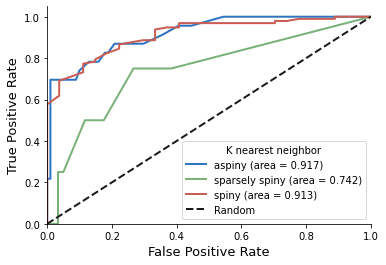

In [20]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

fig = plt.figure(figsize=(5.8, 4))
ax = fig.add_subplot(1, 1, 1)
for i, color in zip(range(3), kcolor[1:4]):
    plt.plot(fpr_knnb[i], tpr_knnb[i], color=color, lw=2, 
             label=target_names[i] + ' (area = '+str(roc_auc_knnb[i])[:5]+')')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.legend(title='K nearest neighbor', loc="lower right")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

### Support vector machine

In [21]:
f1_svm = []; acy_svm = []
conf_svm = np.zeros((3, 3))

# construct svm classifier
svm_clf = svm.SVC(C=15)

for n in range(100):
    # split dataset to training and test
    train_value, test_value, train_label, test_label = train_test_split(X, y, test_size=0.3, stratify=y)
    # train classifier
    svm_clf.fit(train_value, train_label)

    # make predictions
    svm_predictions = svm_clf.predict(test_value)
    
    # calculate evaluation parameters
    f1_svm.append(metrics.f1_score(test_label, svm_predictions, average='weighted'))
    acy_svm.append(metrics.accuracy_score(test_label, svm_predictions))
    conf = metrics.confusion_matrix(test_label, svm_predictions, normalize='true')
    conf_svm += conf

No handles with labels found to put in legend.
No handles with labels found to put in legend.


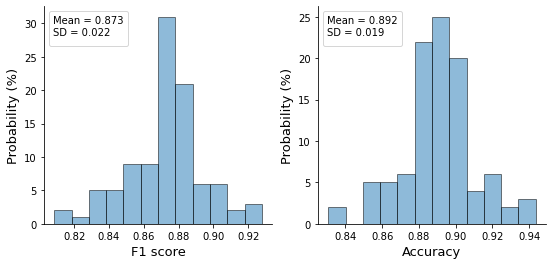

In [22]:
fig = plt.figure(figsize=(9, 4))
plt.tight_layout()
# f1 score
ax = fig.add_subplot(1, 2, 1)
plt.hist(f1_svm, bins=12, alpha=0.5, edgecolor='black', linewidth=1)
plt.xlabel('F1 score', fontsize=13)
plt.ylabel('Probability (%)', fontsize=13)
plt.legend(title = 'Mean = '+str(np.array(f1_svm).mean())[:5]+ '\nSD = '+str(np.std(np.array(f1_svm)))[:5], loc='upper left')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# accuracy
ax = fig.add_subplot(1, 2, 2)
plt.hist(acy_svm, bins=12, alpha=0.5, edgecolor='black', linewidth=1)
plt.xlabel('Accuracy', fontsize=13)
plt.ylabel('Probability (%)', fontsize=13)
plt.legend(title = 'Mean = '+str(np.array(acy_svm).mean())[:5]+ '\nSD = '+str(np.std(np.array(acy_svm)))[:5], loc='upper left')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

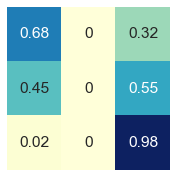

In [23]:
sns.set(rc={'figure.figsize':(3,3)})
sns.set(font_scale=1.3)
sns.heatmap(conf_svm/100, annot=True, xticklabels=[], yticklabels =[], cmap='YlGnBu', square=True, vmax=1, vmin=0, cbar=False)

In [24]:
svm_clf = svm.SVC(C=15, probability=True)
train_value, test_value, train_label, test_label = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)
svm_clf.fit(train_value, train_label)
svm_predictions = svm_clf.predict_proba(test_value)

# Compute ROC curve and ROC area for each class
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()
for i in range(3):
    fpr_svm[i], tpr_svm[i], _ = metrics.roc_curve(label_binarize(test_label, classes=[0, 1, 2])[:,i], 
                                                  svm_predictions[:,i]) # binarize labels
    roc_auc_svm[i] = metrics.auc(fpr_svm[i], tpr_svm[i])

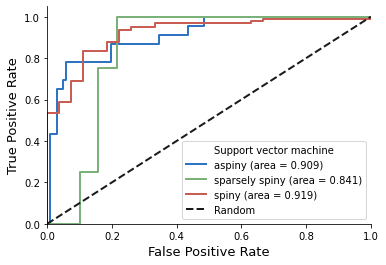

In [25]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

fig = plt.figure(figsize=(5.8, 4))
ax = fig.add_subplot(1, 1, 1)
for i, color in zip(range(3), kcolor[1:4]):
    plt.plot(fpr_svm[i], tpr_svm[i], color=color, lw=2, label=target_names[i] + ' (area = '+str(roc_auc_svm[i])[:5]+')')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.legend(title='Support vector machine', loc="lower right")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

### Artificial neural network

In [26]:
# exclude sparsely spiny neurons
X_ann = all_df[(all_df['dendrite_type'] != 'sparsely spiny')].drop(['specimen_id', 'dendrite_type', 'structure_area_abbrev'
                                                                    , 'dendrite_label'], axis=1).to_numpy()
y_ann = all_df[all_df['dendrite_type'] != 'sparsely spiny']['dendrite_label']

# one-hot encoding for labels
y_ann = np.array(y_ann)
y_b = np.zeros((len(y_ann), 2))
for n in range(len(y_ann)):
    if y_ann[n]:
        y_b[n,:] = [0, 1]
    else:
        y_b[n,:] = [1, 0]

In [27]:
# construct ann model
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model = Sequential()
model.add(Dense(24, activation='sigmoid', input_shape=(40,)))
model.add(Dropout(0.2))
model.add(Dense(12, activation='sigmoid'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'] )

In [28]:
f1_ann = []; acy_ann = []
conf_ann = np.zeros((2, 2))

for n in range(100):
    # split dataset to training and test
    train_value, test_value, train_label, test_label, maxAttr, minAttr = ANN_setup(X_ann, y_b)
    exl_n = len(train_label)-2*(train_label[:,0]==1).sum()
    train_value, train_label = exl_sample(train_value, train_label, exl_n, 1)
    # train classifier
    model.fit(train_value, train_label, epochs=50, batch_size=32, verbose=3)

    # make predictions
    preds = model.predict(test_value)
    
    # calculate evaluation parameters
    f1_ann.append(metrics.f1_score(tf.argmax(test_label, axis=1), tf.argmax(preds, axis=1)))
    acy_ann.append(metrics.accuracy_score(tf.argmax(test_label, axis=1), tf.argmax(preds, axis=1)))
    conf = metrics.confusion_matrix(tf.argmax(test_label, axis=1), tf.argmax(preds, axis=1), normalize='true')
    conf_ann += conf

Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoc

Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoc

Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Trai

Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch

Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoc

Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoc

Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoc

Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Train on 110 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38

No handles with labels found to put in legend.
No handles with labels found to put in legend.


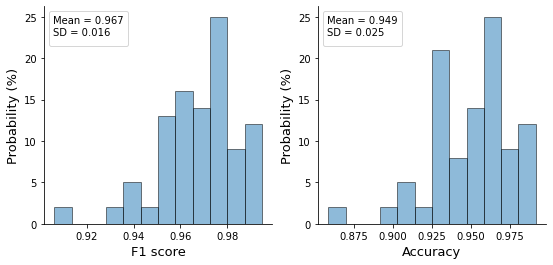

In [29]:
fig = plt.figure(figsize=(9, 4))
plt.tight_layout()
# f1 score
ax = fig.add_subplot(1, 2, 1)
plt.hist(f1_ann, bins=12, alpha=0.5, edgecolor='black', linewidth=1)
plt.xlabel('F1 score', fontsize=13)
plt.ylabel('Probability (%)', fontsize=13)
plt.legend(title = 'Mean = '+str(np.array(f1_ann).mean())[:5]+ '\nSD = '+str(np.std(np.array(f1_ann)))[:5], loc='upper left')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# accuracy
ax = fig.add_subplot(1, 2, 2)
plt.hist(acy_ann, bins=12, alpha=0.5, edgecolor='black', linewidth=1)
plt.xlabel('Accuracy', fontsize=13)
plt.ylabel('Probability (%)', fontsize=13)
plt.legend(title = 'Mean = '+str(np.array(acy_ann).mean())[:5]+ '\nSD = '+str(np.std(np.array(acy_ann)))[:5], loc='upper left')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

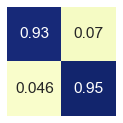

In [30]:
sns.set(rc={'figure.figsize':(2,2)})
sns.set(font_scale=1.3)
sns.heatmap(conf_ann/100, annot=True, xticklabels=[], yticklabels =[], cmap='YlGnBu', square=True, vmax=1, vmin=0, cbar=False)

In [31]:
train_value, test_value, train_label, test_label, maxAttr, minAttr = ANN_setup(X_ann, y_b, random_state=40)
model.fit(train_value, train_label, epochs=50, batch_size=32, verbose=3)
preds = model.predict_proba(test_value)

# Compute ROC curve and ROC area for each class
fpr_ann = dict()
tpr_ann = dict()
roc_auc_ann = dict()
preds_b = np.delete(label_binarize(np.argmax(preds, axis=1), classes=[0, 1, 2]), 2, axis=1)

for i in range(2):
    fpr_ann[i], tpr_ann[i], _ = metrics.roc_curve(test_label[:,i], preds[:,i])
    roc_auc_ann[i] = metrics.auc(fpr_ann[i], tpr_ann[i])

Train on 279 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


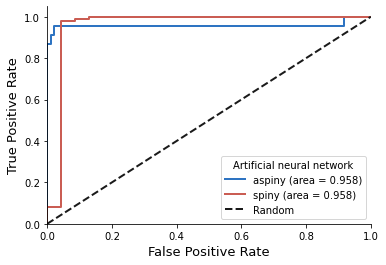

In [32]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

fig = plt.figure(figsize=(5.8, 4))
ax = fig.add_subplot(1, 1, 1)
plt.plot(fpr_ann[0], tpr_ann[0], color=kcolor[1], lw=2, label=target_names[0] + ' (area = '+str(roc_auc_ann[0])[:5]+')')
plt.plot(fpr_ann[1], tpr_ann[1], color=kcolor[3], lw=2, label=target_names[2] + ' (area = '+str(roc_auc_ann[1])[:5]+')')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.legend(title='Artificial neural network', loc="lower right")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

### Classification on 20 features

In [33]:
# select 20 features that have less correlation with each other
# exclude three features detected from nomalized MI
df_copy = all_df.drop(columns = ['specimen_id', 'dendrite_type', 'structure_area_abbrev','dendrite_type', 
                                'adaptation', 'threshold_i_long_square', 'threshold_t_short_square']) 

corr_matrix = df_copy.corr()
covhcluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0.333).fit(corr_matrix)

lst_n_corr = []
lst_corr = []
for n in covhcluster.labels_:
    if covhcluster.labels_[n] not in lst_n_corr:
        lst_n_corr.append(covhcluster.labels_[n])
        lst_corr.append(list(corr_matrix.columns)[n])

In [34]:
sel20_df = all_df[lst_corr]

# select feature values
X_20 = sel20_df.to_numpy()

In [35]:
f120_rf=[]; acy20_rf=[]
conf_rfs = np.zeros((3, 3))

# construct random forest classifier
rf_clf = RandomForestClassifier(max_features=20, n_estimators=100)

for n in range(100):
    # split dataset to training and test
    train_value, test_value, train_label, test_label = train_test_split(X_20, y, test_size=0.3, stratify=y)
    # train classifier
    rf_clf.fit(train_value, train_label)

    # Make predictions
    rf_predictions = rf_clf.predict(test_value)
    
    f120_rf.append(metrics.f1_score(test_label, rf_predictions, average='weighted'))
    acy20_rf.append(metrics.accuracy_score(test_label, rf_predictions))
    # calculate confusion matrix
    conf = metrics.confusion_matrix(test_label, rf_predictions, normalize='true')
    conf_rfs += conf

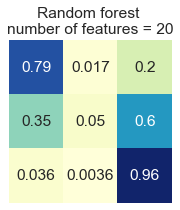

In [36]:
sns.set(rc={'figure.figsize':(3,3)})
sns.set(font_scale=1.3)
sns.heatmap(conf_rfs/100, annot=True, xticklabels=[], yticklabels =[], cmap='YlGnBu', square=True, vmax=1, vmin=0, cbar=False)
plt.title('Random forest \nnumber of features = 20')

In [37]:
f120_knnb=[]; acy20_knnb=[]
conf_knnbs = np.zeros((3, 3))

# construct knn classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn_bag = BaggingClassifier(knn, max_samples=0.5, max_features=0.5)

for n in range(100):
    # split dataset to training and test
    train_value, test_value, train_label, test_label = train_test_split(X_20, y, test_size=0.3, stratify=y)
    # train classifier
    knn_bag.fit(train_value, train_label)

    # Make predictions
    knn_bag_predictions = knn_bag.predict(test_value)
    
    f120_knnb.append(metrics.f1_score(test_label, knn_bag_predictions, average='weighted'))
    acy20_knnb.append(metrics.accuracy_score(test_label, knn_bag_predictions))
    
    # calculate confusion matrix
    confb = metrics.confusion_matrix(test_label, knn_bag_predictions, normalize='true')
    conf_knnbs += confb

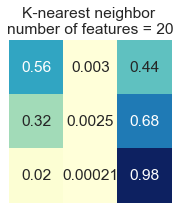

In [38]:
sns.set(rc={'figure.figsize':(3,3)})
sns.set(font_scale=1.3)
sns.heatmap(conf_knnbs/100, annot=True, xticklabels=[], yticklabels =[], cmap='YlGnBu', square=True, vmax=1, vmin=0, cbar=False)
plt.title('K-nearest neighbor \nnumber of features = 20')

In [39]:
f120_svm=[]; acy20_svm=[]
conf_svms = np.zeros((3, 3))

# construct svm classifier
svm_clf = svm.SVC(C=15)#kernel='linear')

for n in range(100):
    # split dataset to training and test
    train_value, test_value, train_label, test_label = train_test_split(X_20, y, test_size=0.3, stratify=y)
    # train classifier
    svm_clf.fit(train_value, train_label)

    # make predictions
    svm_predictions = svm_clf.predict(test_value)
    
    f120_svm.append(metrics.f1_score(test_label, svm_predictions, average='weighted'))
    acy20_svm.append(metrics.accuracy_score(test_label, svm_predictions))
    
    # calculate confusion matrix
    conf = metrics.confusion_matrix(test_label, svm_predictions, normalize='true')
    conf_svms += conf

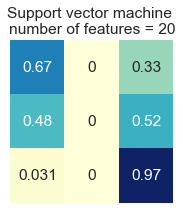

In [40]:
sns.set(rc={'figure.figsize':(3,3)})
sns.set(font_scale=1.3)
sns.heatmap(conf_svms/100, annot=True, xticklabels=[], yticklabels =[], cmap='YlGnBu', square=True, vmax=1, vmin=0, cbar=False)
plt.title('Support vector machine \nnumber of features = 20')

### Classification on 10 features

In [41]:
# selected 10 features with high entropy from 20 features
d_corr_entropy = {}
for feature in lst_corr:
    d_corr_entropy[feature] = calentropy(feature)

df_entropy = pd.DataFrame.from_dict(d_corr_entropy, orient='index', columns=['Entropy'])
lst_entropy = list(df_entropy.sort_values(by=['Entropy'], ascending=False).index[:10])

# select feature values
X_10 = all_df[lst_entropy].to_numpy()

In [42]:
f110_rf=[]; acy10_rf=[]
conf_rfs = np.zeros((3, 3))

# construct random forest classifier
rf_clf = RandomForestClassifier(max_features=10, n_estimators=100)

for n in range(100):
    # split dataset to training and test
    train_value, test_value, train_label, test_label = train_test_split(X_10, y, test_size=0.3, stratify=y)
    # train classifier
    rf_clf.fit(train_value, train_label)

    # Make predictions
    rf_predictions = rf_clf.predict(test_value)
    
    f110_rf.append(metrics.f1_score(test_label, rf_predictions, average='weighted'))
    acy10_rf.append(metrics.accuracy_score(test_label, rf_predictions))
    
    # calculate confusion matrix
    conf = metrics.confusion_matrix(test_label, rf_predictions, normalize='true')
    conf_rfs += conf

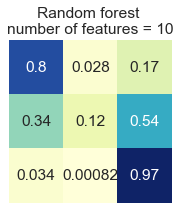

In [43]:
sns.set(rc={'figure.figsize':(3,3)})
sns.set(font_scale=1.3)
sns.heatmap(conf_rfs/100, annot=True, xticklabels=[], yticklabels =[], cmap='YlGnBu', square=True, vmax=1, vmin=0, cbar=False)
plt.title('Random forest \nnumber of features = 10')

In [44]:
f110_knnb=[]; acy10_knnb=[]
conf_knnbs = np.zeros((3, 3))

# construct knn classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn_bag = BaggingClassifier(knn, max_samples=0.5, max_features=0.5)

for n in range(100):
    # split dataset to training and test
    train_value, test_value, train_label, test_label = train_test_split(X_10, y, test_size=0.3, stratify=y)
    # train classifier
    knn_bag.fit(train_value, train_label)

    # Make predictions
    knn_bag_predictions = knn_bag.predict(test_value)
    
    f110_knnb.append(metrics.f1_score(test_label, knn_bag_predictions, average='weighted'))
    acy10_knnb.append(metrics.accuracy_score(test_label, knn_bag_predictions))
    # calculate confusion matrix
    confb = metrics.confusion_matrix(test_label, knn_bag_predictions, normalize='true')
    conf_knnbs += confb

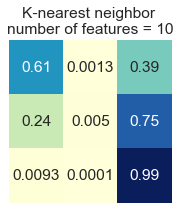

In [45]:
sns.set(rc={'figure.figsize':(3,3)})
sns.set(font_scale=1.3)
sns.heatmap(conf_knnbs/100, annot=True, xticklabels=[], yticklabels =[], cmap='YlGnBu', square=True, vmax=1, vmin=0, cbar=False)
plt.title('K-nearest neighbor \nnumber of features = 10')

In [46]:
f110_svm=[]; acy10_svm=[]
conf_svms = np.zeros((3, 3))

# construct svm classifier
svm_clf = svm.SVC(C=15)

for n in range(100):
    # split dataset to training and test
    train_value, test_value, train_label, test_label = train_test_split(X_10, y, test_size=0.3, stratify=y)
    # train classifier
    svm_clf.fit(train_value, train_label)

    # make predictions
    svm_predictions = svm_clf.predict(test_value)
    
    f110_svm.append(metrics.f1_score(test_label, svm_predictions, average='weighted'))
    acy10_svm.append(metrics.accuracy_score(test_label, svm_predictions))
    
    # calculate confusion matrix
    conf = metrics.confusion_matrix(test_label, svm_predictions, normalize='true')
    conf_svms += conf

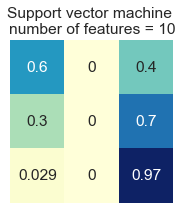

In [47]:
sns.set(rc={'figure.figsize':(3,3)})
sns.set(font_scale=1.3)
sns.heatmap(conf_svms/100, annot=True, xticklabels=[], yticklabels =[], cmap='YlGnBu', square=True, vmax=1, vmin=0, cbar=False)
plt.title('Support vector machine \nnumber of features = 10')

### Summarize

In [48]:
f1 = np.concatenate([np.stack([f1_knnb, f1_rf, f1_svm], axis=1), np.stack([f120_knnb, f120_rf, f120_svm], axis=1), 
                     np.stack([f110_knnb, f110_rf, f110_svm], axis=1)])
acy = np.concatenate([np.stack([acy_knnb, acy_rf, acy_svm], axis=1), np.stack([acy20_knnb, acy20_rf, acy20_svm], axis=1), 
                     np.stack([acy10_knnb, acy10_rf, acy10_svm], axis=1)])
feature_n = np.concatenate([40*np.ones((100, 1)), 20*np.ones((100, 1)), 10*np.ones((100, 1))]).astype(int)

df_f1 = pd.DataFrame(data = np.concatenate([feature_n, f1], axis=1), columns=['feature_n', 'knn', 'rf', 'svm'])
df_f1 = pd.melt(df_f1, id_vars=['feature_n'], value_vars=['knn', 'rf', 'svm'])
df_acy = pd.DataFrame(data = np.concatenate([feature_n, acy], axis=1), columns=['feature_n', 'knn', 'rf', 'svm'])
df_acy = pd.melt(df_acy, id_vars=['feature_n'], value_vars=['knn', 'rf', 'svm'])

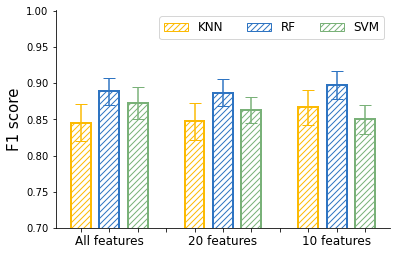

In [49]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(1, 1, 1)
inx = np.arange(11)

for i in range(3):
    for j in range(3):
        plt.bar(inx[i*3+i+j], f1[i*100:i*100+100, j].mean(axis=0), yerr=f1[i*100:i*100+100, j].std(axis=0), width=0.7, 
        color='none', edgecolor=kcolor[j], ecolor=kcolor[j], linewidth=2, hatch='////', capsize=6)

plt.ylim(top=1.001, bottom=0.7)
patch1 = mpatches.Patch(facecolor='w', edgecolor=kcolor[0], label='KNN', hatch='////')
patch2 = mpatches.Patch(facecolor='w', edgecolor=kcolor[1], label='RF', hatch='////')
patch3 = mpatches.Patch(facecolor='w', edgecolor=kcolor[2], label='SVM', hatch='////')

plt.legend(prop={'size':12}, handles=[patch1, patch2, patch3], ncol=3)

plt.xticks(inx, ('','All features','','','','20 features','','','','10 features'), fontsize=12)
plt.ylabel('F1 score', fontsize=15)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

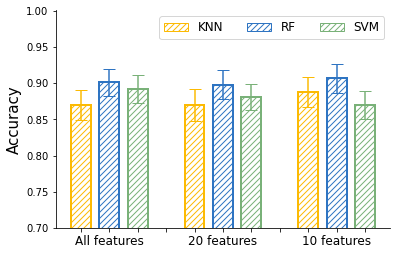

In [51]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(1, 1, 1)
inx = np.arange(11)

for i in range(3):
    for j in range(3):
        plt.bar(inx[i*3+i+j], acy[i*100:i*100+100, j].mean(axis=0), yerr=acy[i*100:i*100+100, j].std(axis=0), width=0.7, 
        color='none', edgecolor=kcolor[j], ecolor=kcolor[j], linewidth=2, hatch='////', capsize=6)

plt.ylim(top=1.001, bottom=0.7)
patch1 = mpatches.Patch(facecolor='w', edgecolor=kcolor[0], label='KNN', hatch='////')
patch2 = mpatches.Patch(facecolor='w', edgecolor=kcolor[1], label='RF', hatch='////')
patch3 = mpatches.Patch(facecolor='w', edgecolor=kcolor[2], label='SVM', hatch='////')

plt.legend(prop={'size':12}, handles=[patch1, patch2, patch3], ncol=3)

plt.xticks(inx, ('','All features','','','','20 features','','','','10 features'), fontsize=12)
plt.ylabel('Accuracy', fontsize=15)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

In [61]:
df_f1.to_csv('f1.csv', index=False)
df_acy.to_csv('acy.csv', index=False)